In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', 1000)

In [6]:
os.listdir("/data/temiloluwa.adeoti/fourth_experiments")

['CIFAR10_clus_768_neg_256',
 'CIFAR10_clus_768_neg_512',
 'CIFAR10_clus_2816_neg_2560',
 'CIFAR10_clus_768_neg_2560']

In [3]:
pd.read_pickle("/data/temiloluwa.adeoti/fourth_experiments/CIFAR10_clus_72_neg_32/exp_203/checkpoints/prototypes/prototypes.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/data/temiloluwa.adeoti/fourth_experiments/CIFAR10_clus_72_neg_32/exp_203/checkpoints/prototypes/prototypes.pickle'

In [2]:
data_path = "/data/temiloluwa.adeoti/third_experiments/CIFAR10_clus_2816_neg_2560/exp_0/checkpoint_199_results/ood_results/metrics_result/contrastive_enc_key_ckpt_199_avg_pool/cache"

In [3]:
paths = list(Path(data_path).iterdir())
{i:v.stem for i, v in enumerate(paths)}

{0: 'CIFAR10_avg_pool_test_features',
 1: 'CIFAR10_avg_pool_train_features',
 2: 'SVHN_avg_pool_train_target',
 3: 'CIFAR100_avg_pool_test_features',
 4: 'SVHN_avg_pool_test_target',
 5: 'SVHN_avg_pool_test_features',
 6: 'CIFAR100_avg_pool_train_features',
 7: 'CIFAR100_avg_pool_train_target',
 8: 'CIFAR10_avg_pool_test_target',
 9: 'CIFAR10_avg_pool_train_target',
 10: 'SVHN_avg_pool_train_features',
 11: 'CIFAR100_avg_pool_test_target',
 12: 'CIFAR10_avg_pool_accuracies'}

In [4]:
def cosine(x, support_mean):
    n = x.shape[0]
    m = support_mean.shape[0]
    sim = cosine_similarity(x, support_mean)

    assert sim.shape == (n,m), "error occured"

    return sim

In [5]:
clusters = [1, 5, 10, 20, 30]
cifar_10_train_feats = np.load(paths[1])
cifar_10_test_feats = np.load(paths[0])
cifar_100_test_feats = np.load(paths[3])
distances = {}

In [6]:
for clus in clusters:
    print(f"Processing cluster {clus}")
    if clus == 1:
        labels = np.zeros(len(cifar_10_train_feats))
        centroids = np.mean(cifar_10_train_feats, axis=0).reshape(1, -1)
    else:
        kmeans = KMeans(n_clusters=clus, init="k-means++", random_state=5).fit(cifar_10_train_feats)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
    in_classes = np.unique(labels).astype(int)
    class_idx = [np.where(labels == i)[0] for i in in_classes]
    in_classes_X = [cifar_10_train_feats[idx] for idx in class_idx]
    
    
    dis = cosine(cifar_10_test_feats, centroids)
    print(f"dis shape, {dis.shape}")
    dis = np.max(dis, axis=1)
    distances[f"cifar_10_test_{clus}"] = dis
    
    dis = cosine(cifar_100_test_feats, centroids)
    dis = np.max(dis, axis=1)
    distances[f"cifar_100_test_{clus}"] = dis

Processing cluster 1
dis shape, (10000, 1)
Processing cluster 5
dis shape, (10000, 5)
Processing cluster 10
dis shape, (10000, 10)
Processing cluster 20
dis shape, (10000, 20)
Processing cluster 30
dis shape, (10000, 30)


Text(0.5, 1.0, 'Cifar_10 Cosine Distances plot for k=20 vs k=1')

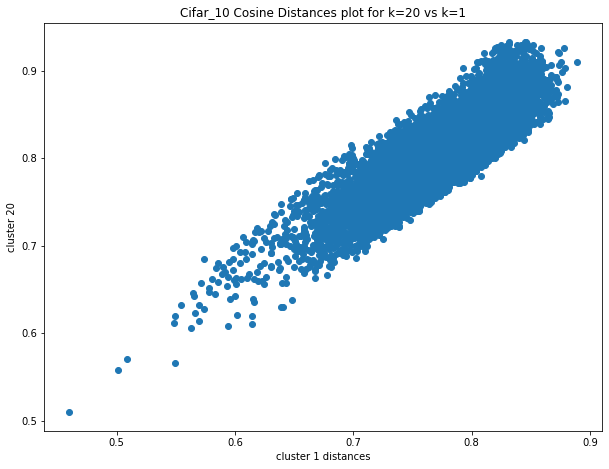

In [13]:
plt.figure(figsize=(10, 7.5))
data = "cifar_10"
clus = 20
x = distances[f"{data}_test_1"]
y = distances[f"{data}_test_{5}"]
plt.scatter(x, y)
plt.ylabel(f"cluster {clus}")
plt.xlabel("cluster 1 distances")
plt.title(f"{data.capitalize()} Cosine Distances plot for k={clus} vs k=1")
#plt.savefig(f"../cache/{data}_cos_clus_{clus}")

['all_SVHN_5_cosine.png',
 'all_LSUNCrop_5_cosine.png',
 'all_LSUNResize_0_cosine.png',
 'all_CIFAR100_0_cosine.png',
 'ensemble_results.pickle',
 'ens_exp_0_temp_1.xlsx',
 'ens_exp_0_temp_2.xlsx',
 'ens_exp_0_temp_3.xlsx',
 'best_results.xlsx']

In [ ]:
data_path = "/data/temiloluwa.adeoti/checkpoints"
results_type = "metrics_result"
res_paths = [i for i in Path(data_path).rglob("*results.pickle") if results_type in str(i)]
{i:v for i, v in enumerate(res_paths)}

In [ ]:
mn = 7
ood = 0
df = pd.DataFrame(pd.read_pickle(res_paths[mn]))
oods = list(df.ood.unique())
df[df.ood==oods[ood]].sort_values(by=["auroc"], ascending=False)

In [ ]:
oods = df.ood.unique()
oods

In [ ]:
ds = "CIFAR100"
pcas = df["pca components"].unique()
pcas.sort()
sns.set_style("whitegrid")

for ds in oods:
    f, axes = plt.subplots(1, 2, figsize=(20, 10))
    for i in range(len(pcas)):
        axes = axes.reshape(1, 2)
        ax_ = axes[i//2, i%2]
        sns.lineplot(data=df[(df.ood==ds) & (df["pca components"]==pcas[i])],\
               x="clusters", y="auroc", hue="metric", ax=ax_)
        ax=ax_.set_title(f"{ds} PCA {pcas[i]}")
     #plt.savefig(os.path.join(path, f"{ds}_auroc_v_clusters.jpg"))



In [ ]:
for ds in oods:
    f, axes = plt.subplots(1, 2, figsize=(20, 10))
    for i in range(len(pcas)):
        axes = axes.reshape(1, 2)
        ax_ = axes[i//2, i%2]
        sns.lineplot(data=df[(df.ood==ds) & (df["pca components"]==pcas[i])],\
               x="clusters", y="tnr@tpr95", hue="metric", ax=ax_)
        ax=ax_.set_title(f"{ds} PCA {pcas[i]}")

In [2]:
os.chdir("../")

In [4]:
from imagereconstruction import *

In [5]:
encoder = models.__dict__['resnet50'](num_classes=num_classes).cuda(gpu)
encoder = load_contrastive_model(ckpt_root, config, 128, encoder)
encoder = attach_hook(encoder)
encoder = freeze_encoder(encoder)

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder
        self.decoder = Decoder().cuda(gpu)

    def forward(self, x):
        self.encoder(x)
        o = self.encoder.enc_output
        features = [self.encoder.output3, self.encoder.output2, self.encoder.output1]
        o = self.decoder(o, features)
        return o

model = AutoEncoder()
optimizer = torch.optim.SGD(model.parameters(), lr)
criterion = nn.MSELoss().cuda(gpu)

train_loader, test_loader = get_ensemble_eval_loaders("CIFAR10", None, batch_size, "CIFAR10", True, shuffle=True)

Contrastive model loaded with dims: 10
param conv1.weight frozen
param bn1.weight frozen
param bn1.bias frozen
param layer1.0.conv1.weight frozen
param layer1.0.bn1.weight frozen
param layer1.0.bn1.bias frozen
param layer1.0.conv2.weight frozen
param layer1.0.bn2.weight frozen
param layer1.0.bn2.bias frozen
param layer1.0.conv3.weight frozen
param layer1.0.bn3.weight frozen
param layer1.0.bn3.bias frozen
param layer1.0.downsample.0.weight frozen
param layer1.0.downsample.1.weight frozen
param layer1.0.downsample.1.bias frozen
param layer1.1.conv1.weight frozen
param layer1.1.bn1.weight frozen
param layer1.1.bn1.bias frozen
param layer1.1.conv2.weight frozen
param layer1.1.bn2.weight frozen
param layer1.1.bn2.bias frozen
param layer1.1.conv3.weight frozen
param layer1.1.bn3.weight frozen
param layer1.1.bn3.bias frozen
param layer1.2.conv1.weight frozen
param layer1.2.bn1.weight frozen
param layer1.2.bn1.bias frozen
param layer1.2.conv2.weight frozen
param layer1.2.bn2.weight frozen
para

In [6]:
ckpt_path = "./cache/visual_model.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=f"cuda:{2}")
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
model

AutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [8]:
eval_data = next(iter(test_loader))

In [49]:
def normalize(x):
    return x - x.max()/(x.max() - x.min())

In [45]:
gpu = 2
#eval_indices = []
model.cuda(gpu)
model.eval()
_target = eval_data[1].detach().cpu().numpy()
_input = eval_data[0].cuda(gpu)
_input_numpy = _input.detach().cpu().numpy()
output = model(_input)
output = output.detach().cpu().numpy()
print("output", output.shape, "type ",  type(output))

output (512, 3, 224, 224) type  <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'output: class bird')

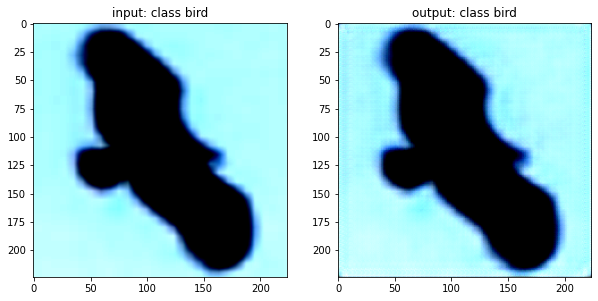

In [61]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
index = 160
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)
ax[0].imshow(_input_numpy[index].transpose(1,2,0))
ax[0].set_title(f"input: class {classes[_target[index]]}")
ax[1].imshow(output[index].transpose(1,2,0))
ax[1].set_title(f"output: class {classes[_target[index]]}")